# Exploratory Data Analysis on UCI Drug Review Dataset



Цель проекта: По текстовым отзывам на различные лекарства предсказать оценку, которую поставил покупатель.
Задачи:
* Разведывательный анализ данных и принятие решений по очистке, предобработке данных и подбору модели на его основе.
* Предобработка данных и Feature Engineering.
* Подбор и обучение модели, оценка её перформанса.

В данном ноутбуке представлен разведывательный анализ данных.

## IMPORT

In [43]:
#downloading extra libraries
# !wget https://raw.githubusercontent.com/tylerneylon/explacy/master/explacy.py
# !pip install spacytextblob --upgrade
# ! python -m textblob.download_corpora
# !pip install spacy --upgrade
# !python -m spacy download en_core_web_sm

2021-09-01 09:51:24.498005: W tensorflow/stream_executor/platform/default/dso_loader.cc:60] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/conda/lib
2021-09-01 09:51:24.498075: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
     |████████████████████████████████| 13.6 MB 15.5 MB/s eta 0:00:01
  Attempting uninstall: en-core-web-sm
    Found existing installation: en-core-web-sm 2.3.1
    Uninstalling en-core-web-sm-2.3.1:
      Successfully uninstalled en-core-web-sm-2.3.1
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


In [13]:
#tabular data handling
import pandas as pd
import numpy as np
#plotting figures
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
#text data handling
import spacy
import explacy
from spacytextblob.spacytextblob import SpacyTextBlob

pd.set_option('display.max_colwidth', -1) # чтобы не сокращать текст ревью
plt.style.use('ggplot')

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:13: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  del sys.path[0]


## DATA

In [14]:
train = pd.read_csv('../input/uci-drug-review-dataset/drugLibTrain_raw.tsv', sep='\t')
test = pd.read_csv('../input/uci-drug-review-dataset/drugLibTest_raw.tsv', sep='\t')

In [15]:
train.head(5)

,Unnamed: 0,urlDrugName,rating,effectiveness,sideEffects,condition,benefitsReview,sideEffectsReview,commentsReview
0,2202,enalapril,4,Highly Effective,Mild Side Effects,management of congestive heart failure,slowed the progression of left ventricular dysfunction into overt heart failure \r\r\nalone or with other agents in the managment of hypertension \r\r\nmangagement of congestive heart failur,"cough, hypotension , proteinuria, impotence , renal failure , angina pectoris , tachycardia , eosinophilic pneumonitis, tastes disturbances , anusease anorecia , weakness fatigue insominca weakness","monitor blood pressure , weight and asses for resolution of fluid"
1,3117,ortho-tri-cyclen,1,Highly Effective,Severe Side Effects,birth prevention,"Although this type of birth control has more cons than pros, it did help with my cramps. It's also effective with the prevention of pregnancy. (Along with use of condoms as well)","Heavy Cycle, Cramps, Hot Flashes, Fatigue, Long Lasting Cycles. It's only been 5 1/2 months, but i'm concidering changing to a different bc. This is my first time using any kind of bc, unfortunately due to the constant hassel, i'm not happy with the results.","I Hate This Birth Control, I Would Not Suggest This To Anyone."
2,1146,ponstel,10,Highly Effective,No Side Effects,menstrual cramps,"I was used to having cramps so badly that they would leave me balled up in bed for at least 2 days. The Ponstel doesn't take the pain away completely, but takes the edge off so much that normal activities were possible. Definitely a miracle medication!!",Heavier bleeding and clotting than normal.,"I took 2 pills at the onset of my menstrual cramps and then every 8-12 hours took 1 pill as needed for about 3-4 days until cramps were over. If cramps are bad, make sure to take every 8 hours on the dot because the medication stops working suddenly and unfortunately takes about an hour to an hour and a half to kick back in.. if cramps are only moderate, taking every 12 hours is okay."
3,3947,prilosec,3,Marginally Effective,Mild Side Effects,acid reflux,"The acid reflux went away for a few months after just a few days of being on the drug. The heartburn started again as soon as I stopped taking it. So I began treatment again. 6 months passed and I stopped taking it. The heartburn came back, and seemed worse even. The doctor said I should try another 6 month treatment. I did, and the same exact thing happened. This went on for about three years. I asked why this wasn't curing my reflux. The doctor quite frankly told me that it wasn't a cure, but a ""treatment for the symptoms"". I was told that I would probably be on it for the rest of my life.","Constipation, dry mouth and some mild dizziness that would go away after medication was stopped for a few days.","I was given Prilosec prescription at a dose of 45mg per day. Medication was taken once, every morning before eating. Each treatment duration was for 6 months."
4,1951,lyrica,2,Marginally Effective,Severe Side Effects,fibromyalgia,"I think that the Lyrica was starting to help with the pain, but the side-effects were just too severe to continue.",I felt extremely drugged and dopey. Could not drive at all while on this med. Also had extreme ankle and feet swelling and couldn't even wear shoes.,See above


In [16]:
test.head(5)

,Unnamed: 0,urlDrugName,rating,effectiveness,sideEffects,condition,benefitsReview,sideEffectsReview,commentsReview
0,1366,biaxin,9,Considerably Effective,Mild Side Effects,sinus infection,"The antibiotic may have destroyed bacteria causing my sinus infection. But it may also have been caused by a virus, so its hard to say.","Some back pain, some nauseau.",Took the antibiotics for 14 days. Sinus infection was gone after the 6th day.
1,3724,lamictal,9,Highly Effective,Mild Side Effects,bipolar disorder,"Lamictal stabilized my serious mood swings. One minute I was clawing up the walls in pure mania, the next curled up in a fetal position on my bed contemplating suicdie. I am no longer at the whim of my moods and neither are those around me. I'm lucky that I started pharmaceuticals almost immediately after I was diagnosed a bipolar. Lamictal gives me amazing clarity to go about my day, honestly assess myself and form real relationships. Lamitcal lifted a fog, I guess you could call it. Now that I'm medicated I realize how cloudy my thought processes used to be. It's a wonderful feeling.\r\r\n\r\r\nInterestingly, I hardly dreamt before beginning Lamictal. I would dream (I mean dream in the sense of being able to imagine pictures and scenes while asleep, not REM) maybe once every two months. Now I dream every night. I found that the closer I take it to bedtime the more frequent and more intense my dreams.","Drowsiness, a bit of mental numbness. If you take too much, you will feel sedated. Since you have to be able to clearly and honestly assess your emotions and thoughts, determining how much medication you need is tough. I found that 400mg works perfectly for me, but that's a high dose. Less than that and I can feel the medicine wearing off prematurely (I like it to last 24hrs, from sleep to sleep). More than that and I feel numb. Some might call it drowsiness, but it's more a sluggishness of the mind for me.\r\r\n\r\r\nBefore I began treating my bipolar disorder, I used to write a fair amount of fiction. It sort of flowed from me. I definitely had the artist's temperament. After Lamictal, though, that inherent creativity fizzled out. It doesn't come spilling out of me while I'm deep into a manic euphoria. I have to work at art now. It's something that requires discipline. If you are in a field which requires creativity, expect to see a change in your output.",Severe mood swings between hypomania and depression with suicide ideation before Lamictal. Began with 10mg and tritrated up to 400mg over a few months. Played around with the dosage to finally arrive at 400mg. Experimented with taking it at different times in the evening. Found that most comfortable time is before sleep.
2,3824,depakene,4,Moderately Effective,Severe Side Effects,bipolar disorder,"Initial benefits were comparable to the brand name version of this drug, Depakote. I had been taking Depakote for several months and experienced great results. When I went to my psychiatrist for an evaluation and re-fill, he accidently prescribed the generic version, Depakene. When I discovered the error, I was told by this doctor that I would experience the same results as Depakote. The positive side effects of the Depakene: balanced mood, improved concentration, improved logical cognition, mental clarity, lessened anxiety and irritability, improved sleep, increase in pleasure about activities","Depakene has a very thin coating, which caused severe heart burn and stomach upset. The discomfort was so unpleasant that it made me not want to take my meds, so I was not taking them consistently as prescribed. This caused my mood to fluctuate again. Even after I switched to the Depakote, my stomach was still uncomfortable for several weeks afterwards. My appetite decreased and food was very unappetizing. Certain foods that I normally enjoy, such as chicken or fish, made me feel extremely queasy when I ate them. I did not like the physical side effect of the drug, and decided to quit my psy

In [17]:
print(train.info(), test.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3107 entries, 0 to 3106
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   Unnamed: 0         3107 non-null   int64 
 1   urlDrugName        3107 non-null   object
 2   rating             3107 non-null   int64 
 3   effectiveness      3107 non-null   object
 4   sideEffects        3107 non-null   object
 5   condition          3106 non-null   object
 6   benefitsReview     3107 non-null   object
 7   sideEffectsReview  3105 non-null   object
 8   commentsReview     3099 non-null   object
dtypes: int64(2), object(7)
memory usage: 218.6+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1036 entries, 0 to 1035
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   Unnamed: 0         1036 non-null   int64 
 1   urlDrugName        1036 non-null   object
 2   rating             1036 no

In [18]:
print(train.dtypes, test.dtypes)

Unnamed: 0           int64 
urlDrugName          object
rating               int64 
effectiveness        object
sideEffects          object
condition            object
benefitsReview       object
sideEffectsReview    object
commentsReview       object
dtype: object Unnamed: 0           int64 
urlDrugName          object
rating               int64 
effectiveness        object
sideEffects          object
condition            object
benefitsReview       object
sideEffectsReview    object
commentsReview       object
dtype: object


In [19]:
print(train.sideEffects.unique())
print(train.effectiveness.unique())

['Mild Side Effects' 'Severe Side Effects' 'No Side Effects'
 'Extremely Severe Side Effects' 'Moderate Side Effects']
['Highly Effective' 'Marginally Effective' 'Ineffective'
 'Considerably Effective' 'Moderately Effective']


В датасете 9 колонок:

* Unnamed: 0 - индекс отзыва, необходимо удалить, не несёт смысловой нагрузки.
* urlDrugName - string, название лекарства, катгориальный признак с high-cardinality
* rating - int,  рейтинг по шкале от одного до девяти, таргет переменная
* effectiveness - string, эффективность или сила лекарства, категориальный признак, 5 уникальных значений
* sideEffects - string, побочные эффекты, категориальный признак, 5 уникальных значений
* condition - string, болезнь или состояние при котором прописывают лекарство, категориальный признак с high-cardinality
* benefitsReview - string, отзывы на преимущества, текст
* sideEffectsReview - string, отзывы на побочные эффекты, текст
* commentsRevies - string, дополнительные комментарии, текст

На первый взгляд данные выглядят достаточно чисто, но попадаются наборы символов разделителей строк вида  "\r\n".  В тестовой части нет пропусков, в тренировочной части есть небольшое количество пропусков в колонках condition, sideEffectsReview и commentsReview.

Дата ревью не указана, темпоральных признаков нет и не может быть сгенерировано.

Пометим тренировочную и тестовую части, сконкатенируем и посмотрим на то как представлены болезни, как распределены отзывы и оценки на препараты.




In [20]:
train['part'] = 0
test['part'] = 1
data = pd.concat([train, test], ignore_index = True)
data.drop('Unnamed: 0', axis=1, inplace=True)

In [21]:
print(f'В датасете представлено {data.urlDrugName.nunique()} уникальных препаратов и {data.condition.nunique()} уникальных болезней/состояний')

В датасете представлено 541 уникальных препаратов и 1807 уникальных болезней/состояний


In [22]:
data.describe()

,rating,part
count,4143.000000,4143.00000
mean,6.946416,0.25006
std,2.948868,0.43310
min,1.000000,0.00000
25%,5.000000,0.00000
50%,8.000000,0.00000
75%,9.000000,0.50000
max,10.000000,1.00000


## Descriptive Stat-s

<AxesSubplot:title={'center':'Топ 20 самых обозреваемых лекарств(рейтинг)'}, xlabel='urlDrugName'>

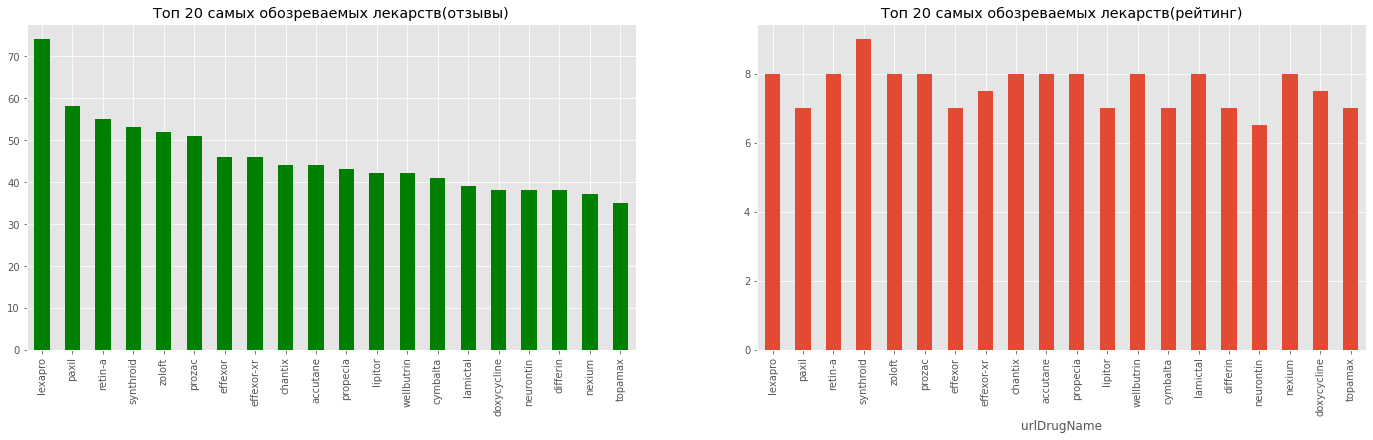

In [23]:
fig, axes = plt.subplots(1,2)
data.urlDrugName.value_counts().nlargest(20).plot(kind='bar',
                                                  title='Топ 20 самых обозреваемых лекарств(отзывы)',
                                                  figsize=(24,6), color = 'green',
                                                  ax=axes[0])
d_names = data.urlDrugName.value_counts().nlargest(20).index.to_list()

data[data.urlDrugName.isin(d_names)].groupby(
        'urlDrugName').agg({'commentsReview':'count',
                                'rating':'median'}).sort_values(
                                'commentsReview',ascending=False)['rating'].plot(kind='bar',
                                title='Топ 20 самых обозреваемых лекарств(рейтинг)',
                                figsize=(24,6),
                                ax=axes[1])

* **lexapro**, **paxil**, **zoloft**, **effexor** и **prozac** - антидепрессанты
* **retin-a** и **accutane** - лекарства от угрей
* **synthroid** - заменитель гормона щитовидной железы
* **chantix** - средство от табакокурения 

<AxesSubplot:title={'center':'Топ 20 самых представленных в датасете болезней (средний рейтинг препаратов)'}, xlabel='condition'>

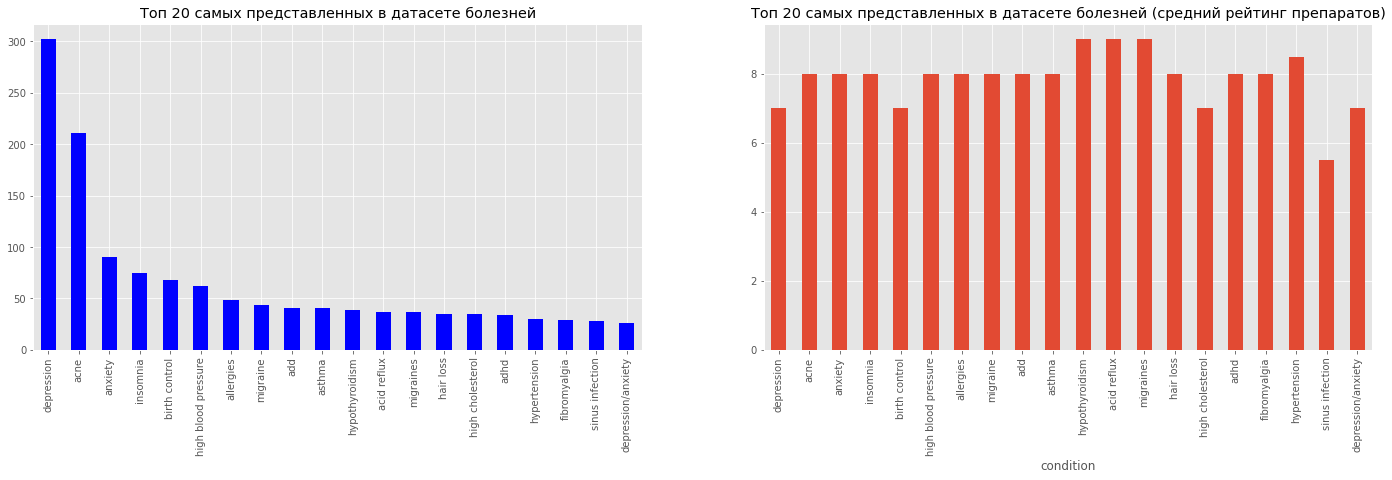

In [24]:
fig, axes = plt.subplots(1,2)
data.condition.value_counts().nlargest(20).plot(kind='bar',
                                                  title='Топ 20 самых представленных в датасете болезней',
                                                  figsize=(12,6),
                                                  color = 'blue',
                                                  ax=axes[0])
c_names = data.condition.value_counts().nlargest(20).index.to_list()

data[data.condition.isin(c_names)].groupby(
        'condition').agg({'commentsReview':'count',
                                'rating':'median'}).sort_values(
                                'commentsReview',ascending=False)['rating'].plot(kind='bar',
                                title='Топ 20 самых представленных в датасете болезней (средний рейтинг препаратов)',
                                figsize=(24,6),
                                ax=axes[1])

<AxesSubplot:>

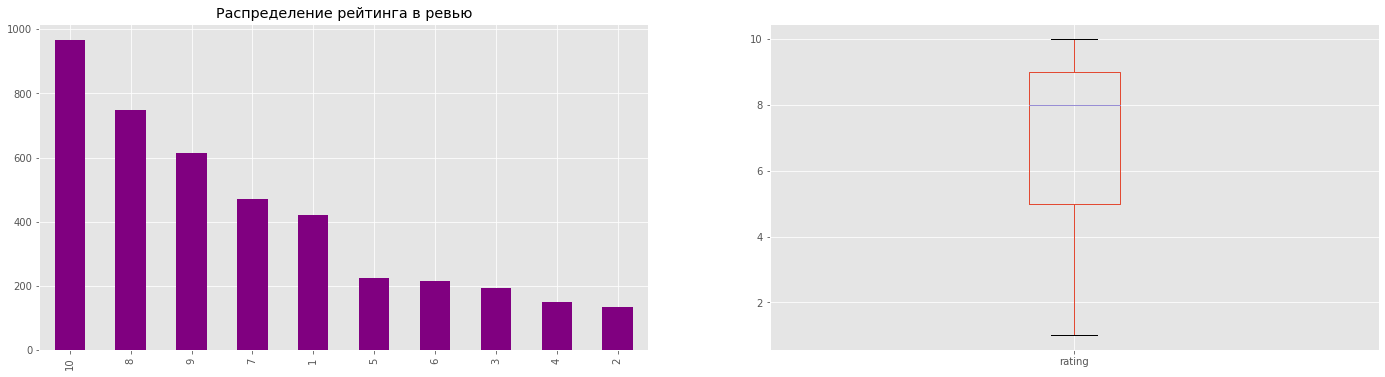

In [25]:
fig, axes = plt.subplots(1,2)
data.rating.value_counts().plot(kind='bar',
                                title='Распределение рейтинга в ревью',
                                figsize=(24,6), color = 'purple',
                                ax=axes[0])
data.boxplot('rating',figsize=(24,6), ax=axes[1])

Из графика видно, что датасет несбалансированный, положительные оценки представлены несколько шире.

Посмотрим на боксплоты оценок разбитых по препаратам и по состояниям.

<AxesSubplot:title={'center':'rating'}, xlabel='urlDrugName'>

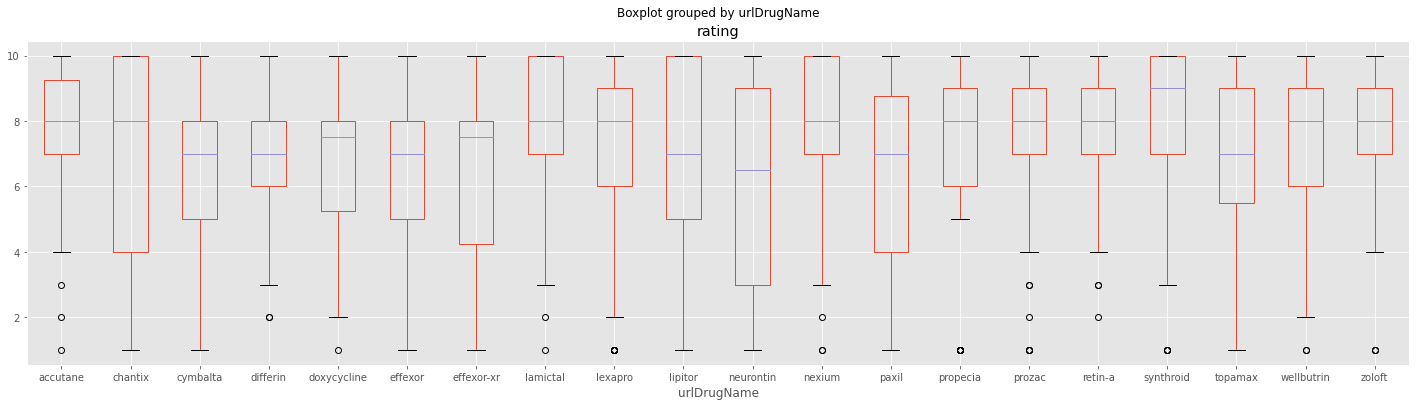

In [26]:
data[data.urlDrugName.isin(d_names)].boxplot('rating', by='urlDrugName',figsize=(24,6))

<AxesSubplot:title={'center':'rating'}, xlabel='condition'>

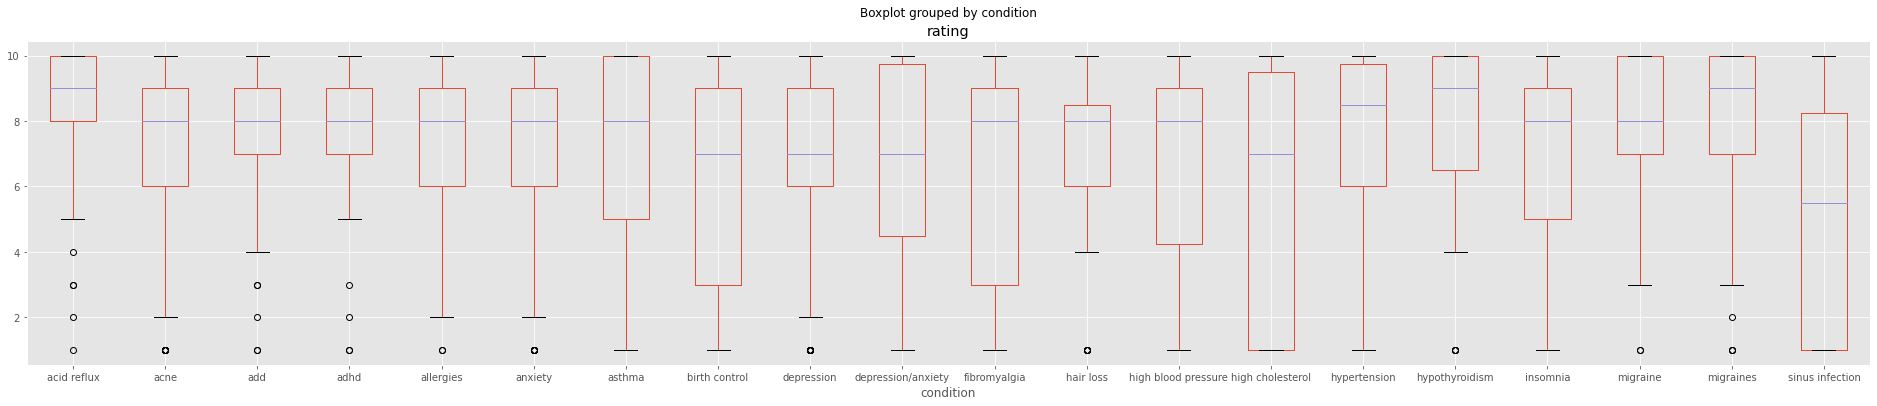

In [27]:
data[data.condition.isin(c_names)].boxplot('rating', by='condition',figsize=(32,6))

По межквартильному размаху некоторых из них можно сделать вывод о противоречивости оценок, возможно это связано с побочными эффектами.

Посмотрим на самые высоко- и низко-оцененные лекарства. Но отсечем все кроме верхнего квартиля по количеству обзоров, чтобы избежать попадания в выборку лекарств с малым количеством ревью.

In [28]:
drug_review_counter = data.groupby('urlDrugName').count()
condition_review_counter = data.groupby('condition').count()

# верхние квантили по количеству обзоров для лекарств и состояний
d_q3 = drug_review_counter.describe()['commentsReview'].loc['75%']
c_q3 = condition_review_counter.describe()['commentsReview'].loc['75%']
d_q3, c_q3

(10.0, 1.0)

In [29]:
agg_func_match = {'commentsReview':'count',
                  'rating': 'median'}
drug_rating = data.groupby('urlDrugName').agg(agg_func_match).query(f'commentsReview >= {d_q3}')
condition_rating = data.groupby('condition').agg(agg_func_match).query(f'commentsReview > {c_q3}')

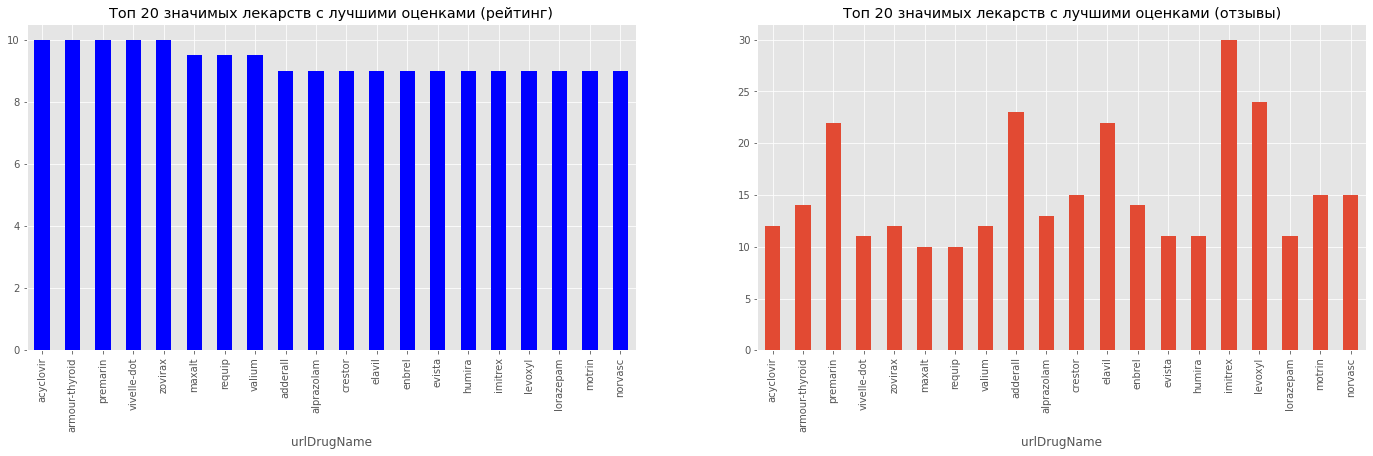

In [30]:
fig, axes = plt.subplots(1, 2)

drug_rating['rating'].nlargest(20).plot(kind='bar',
                  title='Топ 20 значимых лекарств с лучшими оценками (рейтинг)',
                  figsize=(24,6), color='blue', ax=axes[0])

drug_rating.nlargest(20,'rating')['commentsReview'].plot(
                  kind='bar',
                  title='Топ 20 значимых лекарств с лучшими оценками (отзывы)',
                  ax=axes[1]
                  )
plt.show()

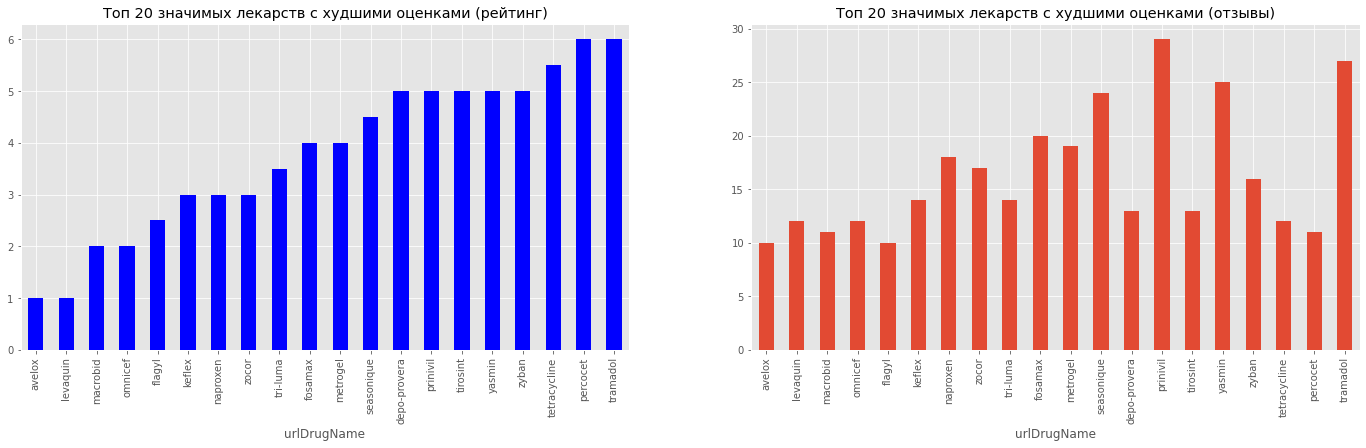

In [31]:
fig, axes = plt.subplots(1, 2)

drug_rating['rating'].nsmallest(20).plot(kind='bar',
                  title='Топ 20 значимых лекарств с худшими оценками (рейтинг)',
                  figsize=(24,6), color='blue', ax=axes[0])

drug_rating.nsmallest(20,'rating')['commentsReview'].plot(
                  kind='bar',
                  title='Топ 20 значимых лекарств с худшими оценками (отзывы)',
                  ax=axes[1]
                  )
plt.show()

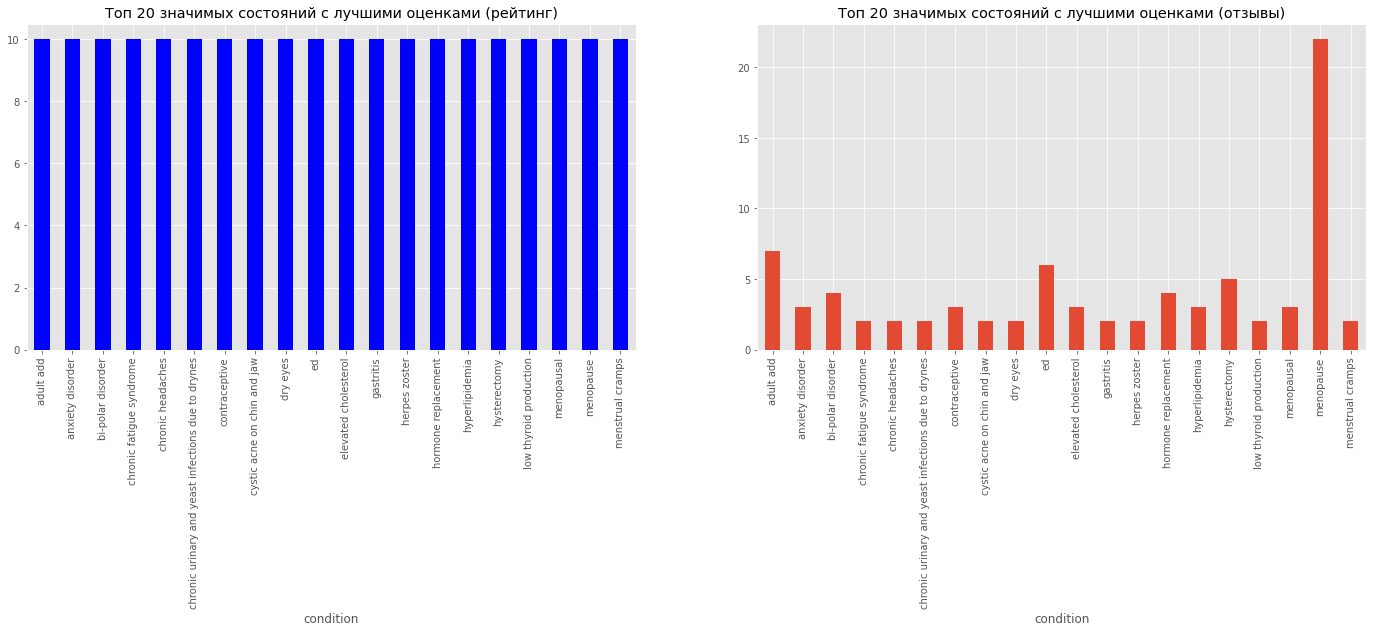

In [32]:
fig, axes = plt.subplots(1, 2)

condition_rating['rating'].nlargest(20).plot(kind='bar',
                  title='Топ 20 значимых состояний с лучшими оценками (рейтинг)',
                  figsize=(24,6), color='blue', ax=axes[0])

condition_rating.nlargest(20,'rating')['commentsReview'].plot(
                  kind='bar',
                  title='Топ 20 значимых состояний с лучшими оценками (отзывы)',
                  ax=axes[1]
                  )
plt.show()

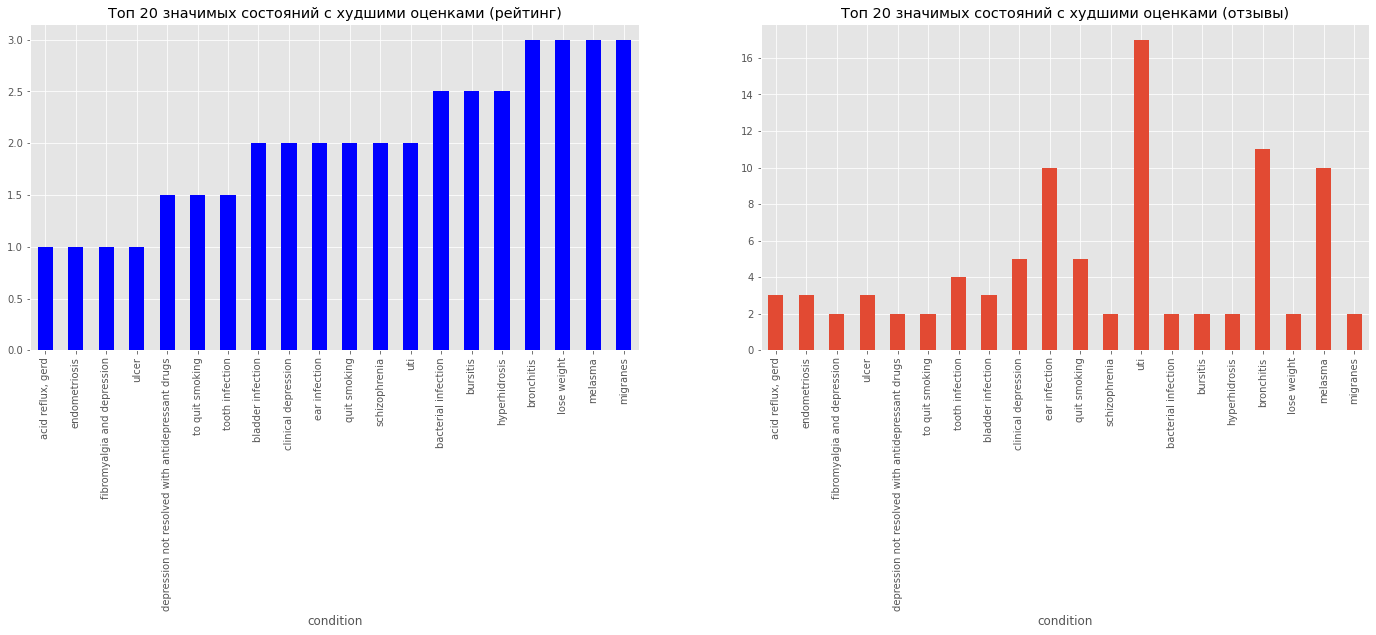

In [33]:
fig, axes = plt.subplots(1, 2)

condition_rating['rating'].nsmallest(20).plot(kind='bar',
                  title='Топ 20 значимых состояний с худшими оценками (рейтинг)',
                  figsize=(24,6), color='blue', ax=axes[0])

condition_rating.nsmallest(20,'rating')['commentsReview'].plot(
                  kind='bar',
                  title='Топ 20 значимых состояний с худшими оценками (отзывы)',
                  ax=axes[1]
                  )
plt.show()

Среди **высокооцененных** лекарств по количеству отзывов сильно выделяются:
**imitrex** (от мигрени), **levoxyl**(гормональный препарат), **elavil**(антидепрессант), **adderall**(антидепрессант), **premarin**(при менопаузе)  
  
Среди **низкооцененных** по количеству отзывов сильно выделяются:
**tramadol**(психотропный анальгетик, опиоид), **yasmin**(противозачаточное), **prinivil**(при артериальной гипертензии), **seasonique**(противозачаточное)

Большое и выделяющееся количество **положительных** оценок к лекарствам при **менопаузе**. Большое количество **отрицательных** оценок к лекарствам при **инфекциях уринального тракта, бронхите, мелазме, и ушных инфекциях.**

Помимо прочего заметил, что местами condition описан в свободной форме или в комбинации с чем-то - типа "fybromialgia and depression" или "depression not resolved with antidepressant drugs". Если использовать этот признак, возможно это требует внимания и дополнительной обработки.

Посмотрим поближе на распределение эффективности и побочных эффектов в датасете.

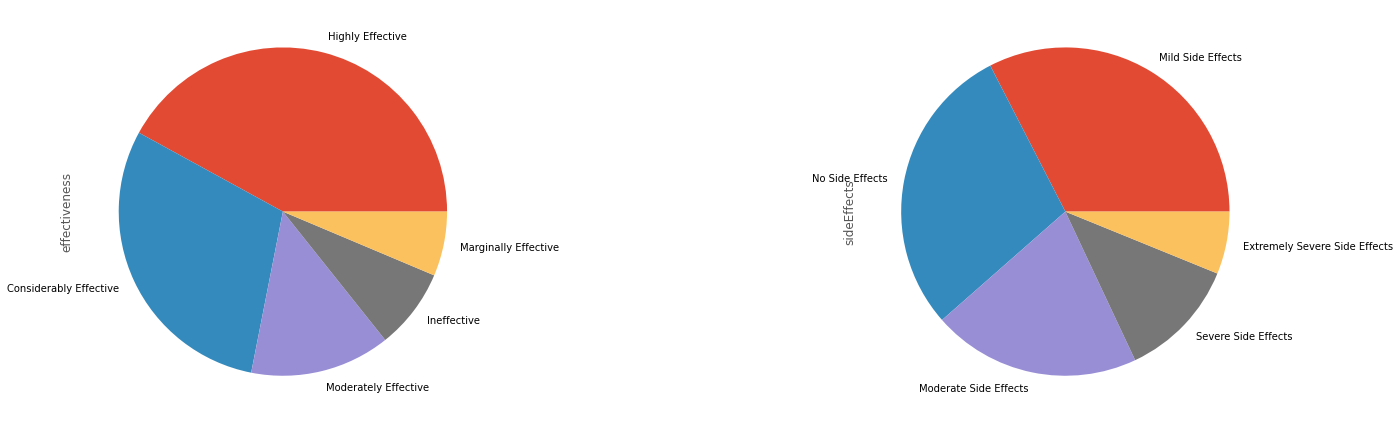

In [34]:
fig, axes = plt.subplots(1,2)
data['effectiveness'].value_counts().plot(kind='pie', figsize=(24,6), ax=axes[0])
data['sideEffects'].value_counts().plot(kind='pie', figsize=(24,6), ax=axes[1])
plt.tight_layout()
plt.show()

In [35]:
# Закодируем категориальные признаки с помощью Label Encoding, чтобы расположить
# их в порядке возрастания
side_effects_dict = {'No Side Effects':0,
                     'Mild Side Effects':1,
                     'Moderate Side Effects':2,
                     'Severe Side Effects':3,
                     'Extremely Severe Side Effects':4}
effectiveness_dict = {'Ineffective':0,
                      'Marginally Effective':1,
                      'Moderately Effective':2,
                      'Considerably Effective':3,
                      'Highly Effective':4}

data['sideEffects'] = data['sideEffects'].map(side_effects_dict)
data['effectiveness'] = data['effectiveness'].map(effectiveness_dict)

<AxesSubplot:xlabel='rating', ylabel='count'>

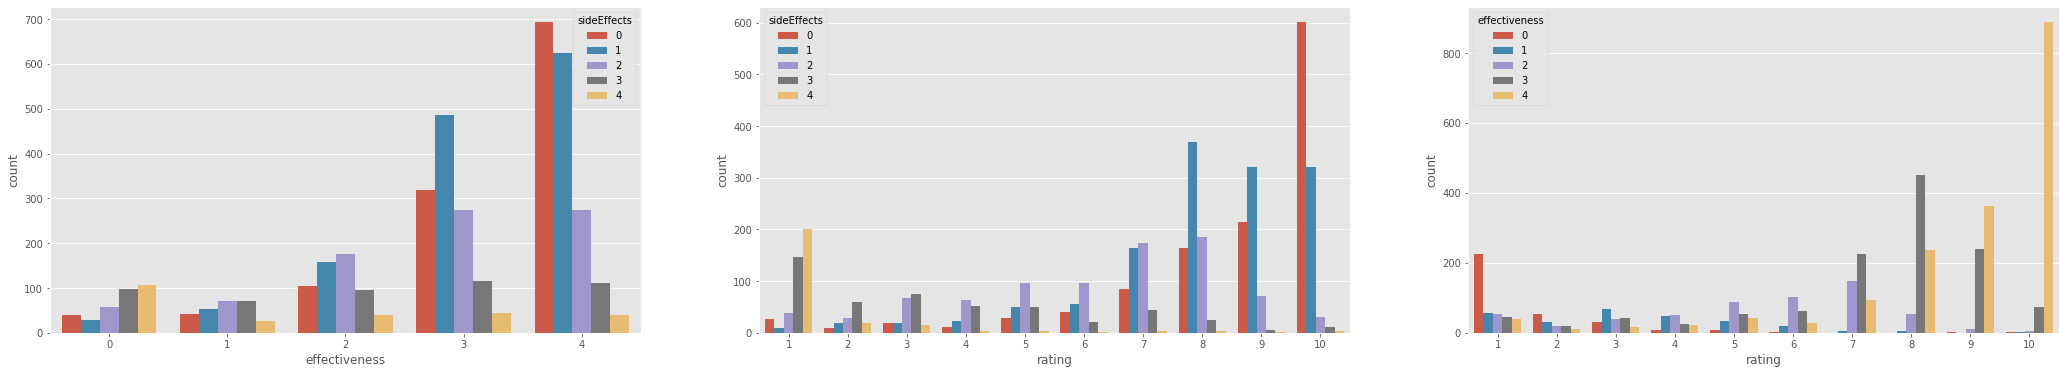

In [36]:
fig, axes = plt.subplots(1,3, figsize= (36,6))
sns.countplot(x='effectiveness', data=data, hue='sideEffects', ax = axes[0])
sns.countplot(x='rating', data=data, hue='sideEffects', ax = axes[1])
sns.countplot(x='rating', data=data, hue='effectiveness', ax = axes[2])

По графикам можно заметить, что среди высокооцененных препараты в основном без или с легкими побочными эффектами, высоко или значительно эффективные. Среди низкооцененных высока доля препаратов с обширными и весьма обширными побочными эффектами и преобладают неэффективные или слабоэффективные препараты.

<AxesSubplot:>

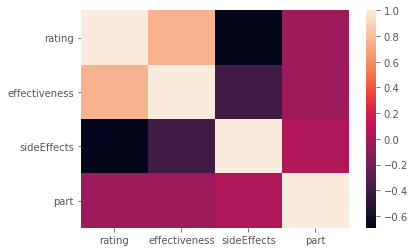

In [37]:
# Тепловая карта матрицы корелляция
sns.heatmap(data.corr())


Видим, что эффективность высоко коррелирует с рейтингом, у побочных эффектов высокая обратная корреляция с рейтингом. Побочные эффекты и эффективность коррелируют средне и обратно.

## Review Text Analysis

В первую очередь обычно необходимо:
* почистить текст от символов разделителей, которые упомянуты выше
* обработать стоп-слова
* токенизировать отзывы

Но стоит учесть, что стоп-слова нужно удалять осторожно, потому что удаление таких конструкций как don't, wouldn't, not превратит отрицательные отзывы в положительные. Для начала попробуем вообще этого не делать, т.к. это скорее всего сильно испортит Sentiment Analysis.

In [39]:
# убираем разделители строк
for col in ['benefitsReview','sideEffectsReview', 'commentsReview']:
    data[col].fillna('',inplace=True)
    data[col] = data[col].apply(lambda x: x.replace('\r\r\n','').lower())

In [40]:
data.head(2)

,urlDrugName,rating,effectiveness,sideEffects,condition,benefitsReview,sideEffectsReview,commentsReview,part
0,enalapril,4,4,1,management of congestive heart failure,slowed the progression of left ventricular dysfunction into overt heart failure alone or with other agents in the managment of hypertension mangagement of congestive heart failur,"cough, hypotension , proteinuria, impotence , renal failure , angina pectoris , tachycardia , eosinophilic pneumonitis, tastes disturbances , anusease anorecia , weakness fatigue insominca weakness","monitor blood pressure , weight and asses for resolution of fluid",0
1,ortho-tri-cyclen,1,4,3,birth prevention,"although this type of birth control has more cons than pros, it did help with my cramps. it's also effective with the prevention of pregnancy. (along with use of condoms as well)","heavy cycle, cramps, hot flashes, fatigue, long lasting cycles. it's only been 5 1/2 months, but i'm concidering changing to a different bc. this is my first time using any kind of bc, unfortunately due to the constant hassel, i'm not happy with the results.","i hate this birth control, i would not suggest this to anyone.",0


In [46]:
sp = spacy.load('en_core_web_sm')
sample = data['sideEffectsReview'].iloc[1]
processed_sample = sp(sample)
print(sample,'\n',processed_sample)

heavy cycle, cramps, hot flashes, fatigue, long lasting cycles. it's only been 5 1/2 months, but i'm concidering changing to a different bc. this is my first time using any kind of bc, unfortunately due to the constant hassel, i'm not happy with the results. 
 heavy cycle, cramps, hot flashes, fatigue, long lasting cycles. it's only been 5 1/2 months, but i'm concidering changing to a different bc. this is my first time using any kind of bc, unfortunately due to the constant hassel, i'm not happy with the results.


На первый взгляд никакой разницы между оригинальной строкой и результатом парсинга spaCy, но мы можем визуализировать что случилось, с помощью библиотеки explaCy.

In [47]:
explacy.print_parse_info(sp,sample)

Dep tree          Token         Dep type  Lemma         Part of Sp
───────────────── ───────────── ───────── ───────────── ──────────
              ┌─► heavy         amod      heavy         ADJ       
   ┌┬┬────────┼── cycle         ROOT      cycle         NOUN      
   │││        └─► ,             punct     ,             PUNCT     
   ││└─►┌─────┬── cramps        conj      cramp         NOUN      
   ││   │     └─► ,             punct     ,             PUNCT     
   ││   │     ┌─► hot           amod      hot           ADJ       
   ││   └─►┌──┼── flashes       conj      flash         NOUN      
   ││      │  └─► ,             punct     ,             PUNCT     
   ││      └─►┌── fatigue       conj      fatigue       NOUN      
   ││         └─► ,             punct     ,             PUNCT     
   ││         ┌─► long          advmod    long          ADV       
   ││      ┌─►└── lasting       amod      last          VERB      
   │└─────►└───── cycles        appos     cycle         NOUN  

In [48]:
review_tokens = pd.DataFrame()

for i, token in enumerate(processed_sample):
    review_tokens.loc[i, 'text'] = token.text
    review_tokens.loc[i, 'lemma'] = token.lemma_,
    review_tokens.loc[i, 'pos'] = token.pos_
    review_tokens.loc[i, 'tag'] = token.tag_
    review_tokens.loc[i, 'dep'] = token.dep_
    review_tokens.loc[i, 'shape'] = token.shape_
    review_tokens.loc[i, 'is_alpha'] = token.is_alpha 
    review_tokens.loc[i, 'is_stop'] = token.is_stop
    review_tokens.loc[i, 'is_punctuation'] = token.is_punct
    review_tokens.loc[i, 'is_digit'] = token.is_digit

review_tokens[:20]

,text,lemma,pos,tag,dep,shape,is_alpha,is_stop,is_punctuation,is_digit
0,heavy,heavy,ADJ,JJ,amod,xxxx,True,False,False,False
1,cycle,"(cycle,)",NOUN,NN,ROOT,xxxx,True,False,False,False
2,",","(,,)",PUNCT,",",punct,",",False,False,True,False
3,cramps,"(cramp,)",NOUN,NNS,conj,xxxx,True,False,False,False
4,",","(,,)",PUNCT,",",punct,",",False,False,True,False
5,hot,"(hot,)",ADJ,JJ,amod,xxx,True,False,False,False
6,flashes,"(flash,)",NOUN,NNS,conj,xxxx,True,False,False,False
7,",","(,,)",PUNCT,",",punct,",",False,False,True,False
8,fatigue,"(fatigue,)",NOUN,NN,conj,xxxx,True,False,False,False
9,",","(,,)",PUNCT,",",punct,",",False,False,True,False


Т.о. на основании данных парсинга можно лемматизировать слова, фильтровать ревью по частям речи, стоп-словам, пунктуации, семантическим тегам и типам символов.

Визуализируем облака слов для ревью.

In [49]:
def plot_cloud(wordcloud):
    """Define a function to plot word cloud"""
    plt.figure(figsize=(24, 6))
    plt.imshow(wordcloud) 
    plt.axis("off")

stop_words = sp.Defaults.stop_words
benefits_wc = WordCloud(width=800, height=400, background_color='white',
                        colormap='viridis', stopwords=stop_words).generate(
                        ' '.join(data['benefitsReview']))
sideeffects_wc = WordCloud(width=800, height=400, background_color='white',
                           colormap = 'autumn', stopwords=stop_words).generate(
                           ' '.join(data['sideEffectsReview']))
comments_wc = WordCloud(width=800, height=400, background_color='white',
                        colormap='terrain', stopwords=stop_words).generate(
                        ' '.join(data['commentsReview']))

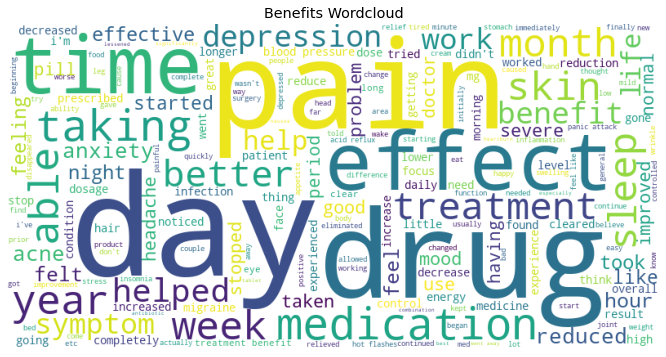

In [50]:
plot_cloud(benefits_wc)
plt.title('Benefits Wordcloud')
plt.show()

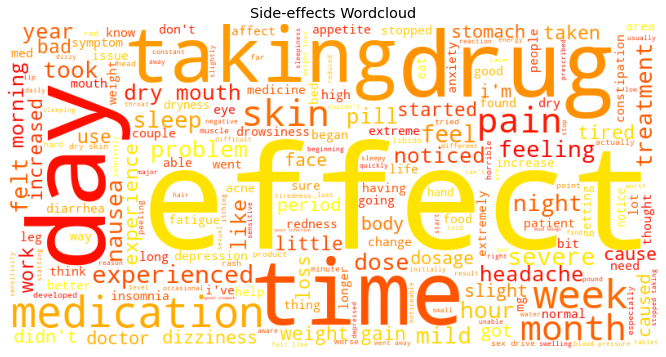

In [51]:
plot_cloud(sideeffects_wc)
plt.title('Side-effects Wordcloud')
plt.show()

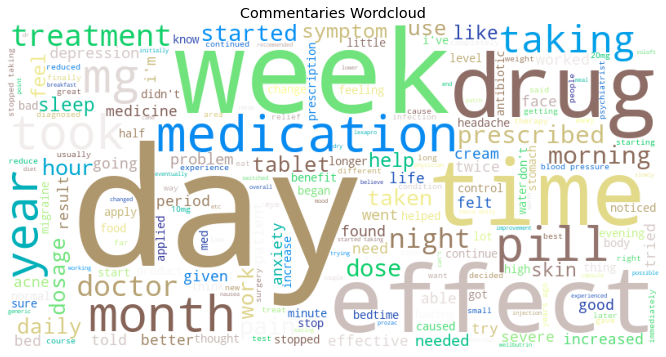

In [52]:
plot_cloud(comments_wc)
plt.title('Commentaries Wordcloud')
plt.show()

На себя перетягивает внимание ряд общеупотребительных слов для всех категорий ревью, таких как: day, month, time, year, month, week. Но можно увидеть характерные слова для преимуществ (helped, decreased,benefit, immediately) и побочных эффектов (nausea, dry mouth, drowsiness, dizziness). Проведем небольшой Sentiment Analysis по текстовым признакам.

In [58]:
sp.add_pipe('spacytextblob')

ValueError: [E007] 'spacytextblob' already exists in pipeline. Existing names: ['tok2vec', 'tagger', 'parser', 'senter', 'attribute_ruler', 'lemmatizer', 'ner', 'spacytextblob']

In [59]:
for col in ['benefitsReview','sideEffectsReview', 'commentsReview']:
    data[f'{col}_polarity'] = data[col].apply(lambda x: sp(x)._.polarity)
    data[f'{col}_subjectivity'] = data[col].apply(lambda x: sp(x)._.subjectivity)

Посмотрим на максимально полярные в обе стороны ревью.

In [94]:
data[data.commentsReview_polarity == data.commentsReview_polarity.max()].loc[:,['commentsReview', 'rating']]

,commentsReview,rating
423,i take sumatriptan at the onset of a migraine. it works best if i am just beginning to notice the pain over my eye.,9
1369,i was seen by my doctor and he thought the medication would be the best route to take for my condition. i was told to put it on my face three time a week at night. however- i used it every night,9
1370,excellent in treating gerd.,7
1519,i followed the doctors instructions perfectly.,1
2702,"i take about 3/4 of a 10mg tablet about 20 to 30 minutes before i go to bed. it is best if i then just go to bed, but i often stay up until it ""kicks in.""",10
3024,began taking a doseage of 35 and increased to 200 mg. at 150 and 200 noticed lack of balance and reduction of motor skills. immediately reduced to 75 which was perfect for the patient but well below the recommended level of 200 to 400 mg.,6
3561,this is taken as needed. it works best to take at the onset of the migraine and not to wait to see if will go away.,10


В большинстве случаев максимальная полярность соответствовала высокой оценке, кроме одного, где важную роль сыграло слово "perfectly"

In [95]:
data[data.commentsReview_polarity == data.commentsReview_polarity.min()].loc[:,['commentsReview', 'rating']]

,commentsReview,rating
2162,awful. thats it.,3
3316,"prescribed 875mg 2x/day for seven days but because of the horrific diarrhea, stopped at five days with doctors consent. never again will i take augmentin -- never.",3
3860,they were terrible.,1


In [97]:
data[data.benefitsReview_polarity == data.benefitsReview_polarity.max()].loc[:,['benefitsReview', 'rating']]

,benefitsReview,rating
1518,excellent birth control,9
2445,this pill is awesome!,10
2582,i slept wonderfully well.,1
3151,cleared up chronic eczema. especially effective on elbows and legs.,10
4100,excellent improvement of papular pustular acne,8


In [98]:
data[data.benefitsReview_polarity == data.benefitsReview_polarity.min()].loc[:,['benefitsReview', 'rating']]

,benefitsReview,rating
1431,none this stuff was awful -it hurt me -dont take it,2
2789,"i have terrible headaches that nothing ever helped, until zomig. it has been a miracle drug for me.",8
3386,"i began taking climara for perimenopause issues-- insomnia, horrible pms, moodiness, night sweats. it helped for these issues.",5


Мощные по смыслу слова сдвигают полярность независимо от контекста.

In [102]:
data[data.sideEffectsReview_polarity == data.sideEffectsReview_polarity.max()].loc[:,['sideEffectsReview', 'rating']]

,sideEffectsReview,rating
3005,"some times i will have aching in my hands and my body like arthritis pain. feels like arthritis, that is the best way i can describe it, but i would rather have that pain than a migraine.",10
3100,"none - i took accutane and it changed my life for the better...i've had none of these side effects that are sometimes reported. my nephew and best friend also took accutane and couldn't be any happier with the results...i'm not depressed, i don't have joint pains or headaches or whatever else is being reported...",7


In [103]:
data[data.sideEffectsReview_polarity == data.sideEffectsReview_polarity.min()].loc[:,['sideEffectsReview', 'rating']]

,sideEffectsReview,rating
552,"insomnia, loss of appitite, stomach pains, when not taken felt real sick, abdominal pain",2
685,horrible nausea.. started almost immediately after taking the pills and would continue for a couple of hours.,1
1183,"the side effects were horrible after one dose - severe dizziness - room spinning. loss of balance. severe nausea, vomiting.",1
1564,"terrible drowsiness and weakness, i could sleep all day then",3
1701,"terrible bruising. if i bump my fingers, the joints will swell.",7
1877,"severe nausea, periods of headache, loss of appetite, horrible taste in mouth (it woke me up 4 times at night), loss of taste",2
2204,"nasty taste in mouth, nausea...... ...... ........... ...................",7
2297,terrible withdrawal,4
2459,"terrible headache and flushing of chest and face. the flushing of the chest and missive headaches happen every time, without exception.",10
2974,"severe neuropsychiatric side effects, including suicide ideation, nightmares, hallucinations, horrible headaches, anger/hostility, reckless/abnormal behavior, dilated pupils, fatigue, pain in joints.",1


<AxesSubplot:>

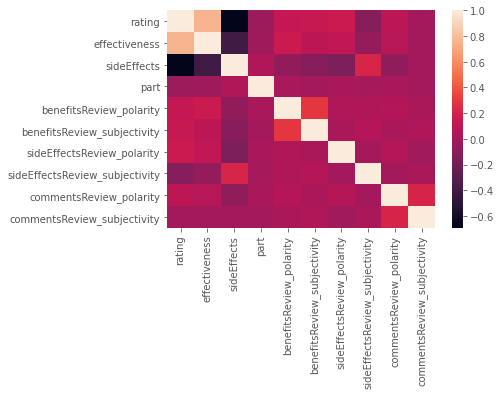

In [104]:
sns.heatmap(data.corr())

## ML

Попробуем для эксперимента построить линейную регрессию по этим данным.

In [84]:
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import mean_squared_error as MSE, classification_report

In [85]:
train = data[data['part']==0]
test = data[data['part']==1]
y_train, y_test = train.rating, test.rating
X_train, X_test = train.drop(['rating','part'], axis=1).select_dtypes(['number']), test.drop(['rating','part'],axis = 1).select_dtypes(['number'])

In [86]:
scaler = StandardScaler()
lr = LinearRegression()
lg = LogisticRegression()

X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [88]:
lr.fit(X_train,y_train)
lg.fit(X_train,y_train)
y_pred = lr.predict(X_test)
y_pred_lg = lg.predict(X_test)
print(f'linreg:{MSE(y_test,y_pred)} logreg:{MSE(y_test,y_pred_lg)}')

linreg:2.187607101214056 logreg:3.4575289575289574


Так как задачу можно решать и как регрессию и как классификацию, посмотрим на классификационные метрики тоже.

In [105]:
print(classification_report(y_test,np.round(y_pred)))
print(classification_report(y_test,np.round(y_pred_lg)))

              precision    recall  f1-score   support

        -0.0       0.00      0.00      0.00         0
         1.0       0.75      0.21      0.33       115
         2.0       0.27      0.18      0.22        33
         3.0       0.09      0.06      0.07        49
         4.0       0.18      0.27      0.21        44
         5.0       0.20      0.34      0.26        67
         6.0       0.15      0.33      0.20        58
         7.0       0.17      0.18      0.18       121
         8.0       0.37      0.25      0.30       190
         9.0       0.33      0.47      0.39       133
        10.0       0.79      0.58      0.67       226

    accuracy                           0.34      1036
   macro avg       0.30      0.26      0.26      1036
weighted avg       0.43      0.34      0.35      1036

              precision    recall  f1-score   support

           1       0.48      0.90      0.62       115
           2       0.00      0.00      0.00        33
           3       0.17 

/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Линейная регрессия посредственно аппроксимирует весь набор данных, хорошо предсказывая только очень хорошие оценки. Логистическая регрессия хорошо работает на очень плохих и очень хороших оценках, но на промежуточных вариантах может не угадывать вообще. В целом хорошей идеей было бы попробовать сократить задачу классификации до бинарной - положительная и отрицательная оценки.

Следующие действия:
* Обучить рекуррентную нейросеть только на текстовых признаках
* От выбора только одной болезни по-видимому можно попробовать отказаться, потому что данных в целом не так много, это как минимум плохо для построения словаря.
* Использовать в качестве представления текстовых данных эмбеддинги, попробовать использовать какие-нибудь предобученные вектора, например glove
* Использовать стоп-слова, т.к. наличие или отсутствие некоторых из них сильно влияет на смысловые коннотации
* Для очистки и токенизации использовать spaCy, для упрощения работы с текстовыми данными - torchtext.